In [6]:
import sys
import os
import json
import torch
import pickle
sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))

from collections import Counter
from models.CNN_BiLSTM import CNN_BiLSTM
from utils import sent2embeddings, label_encode
import torch.nn as nn

/home/kshitij/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/kshitij/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [7]:
with open("../data/train.json") as json_file:
    data = json.load(json_file)

In [8]:
print(f"Number of documents : {len(data)}")

Number of documents : 247


#### Looping through each document

In [9]:
total_sentences = 0
group = []
for index,doc in enumerate(data):
    print(f"Document number : {index}")
    print(f"Number of sentences : {len(doc['annotations'][0]['result'])}")
    total_sentences += len(doc['annotations'][0]['result'])
    group.append(doc['meta']['group'])
    
print(f"Avg sentences = {total_sentences/len(data):.2f}")

Document number : 0
Number of sentences : 91
Document number : 1
Number of sentences : 72
Document number : 2
Number of sentences : 200
Document number : 3
Number of sentences : 119
Document number : 4
Number of sentences : 184
Document number : 5
Number of sentences : 211
Document number : 6
Number of sentences : 140
Document number : 7
Number of sentences : 87
Document number : 8
Number of sentences : 228
Document number : 9
Number of sentences : 99
Document number : 10
Number of sentences : 62
Document number : 11
Number of sentences : 213
Document number : 12
Number of sentences : 111
Document number : 13
Number of sentences : 199
Document number : 14
Number of sentences : 188
Document number : 15
Number of sentences : 271
Document number : 16
Number of sentences : 43
Document number : 17
Number of sentences : 82
Document number : 18
Number of sentences : 171
Document number : 19
Number of sentences : 149
Document number : 20
Number of sentences : 95
Document number : 21
Number of 

In [10]:
print(f"Number of law groups : \n{set(group)}")

Number of law groups : 
{'Tax', 'Criminal'}


#### Looping through each document + sentence

In [11]:
labels = []
for index,doc in enumerate(data):
    char_count = 0
    group = doc['meta']['group']
    print(f"Document number : {index:<6} Law Type : {group}")
    # print(f"Number of sentences : {len(doc['annotations'][0]['result'])}")
    if doc['annotations'][0]['result'] != []:
        for sentence_data in doc['annotations'][0]['result']:
            char_count += len(sentence_data['value']['text'])
            labels.append(sentence_data['value']['labels'][0])
        print(f"Avg number of chars : {char_count/len(doc['annotations'][0]['result']):.2f}")
    else:
        print(f"{'Document is empty':-^60}")

Document number : 0      Law Type : Criminal
Avg number of chars : 180.81
Document number : 1      Law Type : Tax
Avg number of chars : 153.39
Document number : 2      Law Type : Criminal
Avg number of chars : 193.93
Document number : 3      Law Type : Tax
Avg number of chars : 222.87
Document number : 4      Law Type : Tax
Avg number of chars : 183.04
Document number : 5      Law Type : Criminal
Avg number of chars : 143.89
Document number : 6      Law Type : Tax
Avg number of chars : 202.29
Document number : 7      Law Type : Criminal
Avg number of chars : 118.03
Document number : 8      Law Type : Criminal
Avg number of chars : 140.69
Document number : 9      Law Type : Criminal
Avg number of chars : 181.81
Document number : 10     Law Type : Criminal
Avg number of chars : 153.18
Document number : 11     Law Type : Tax
Avg number of chars : 177.47
Document number : 12     Law Type : Tax
Avg number of chars : 156.68
Document number : 13     Law Type : Criminal
Avg number of chars : 1

In [12]:
print(set(labels))

{'ISSUE', 'PRE_RELIED', 'STA', 'PRE_NOT_RELIED', 'RLC', 'RPC', 'NONE', 'FAC', 'ANALYSIS', 'ARG_PETITIONER', 'RATIO', 'PREAMBLE', 'ARG_RESPONDENT'}


In [13]:
Counter(labels)

Counter({'PREAMBLE': 4167,
         'NONE': 1423,
         'FAC': 5744,
         'ARG_RESPONDENT': 698,
         'RLC': 752,
         'ARG_PETITIONER': 1315,
         'ANALYSIS': 10695,
         'PRE_RELIED': 1431,
         'RATIO': 674,
         'RPC': 1081,
         'ISSUE': 367,
         'STA': 481,
         'PRE_NOT_RELIED': 158})

# Training through 1 document

In [57]:
label_encoder = label_encode(list(set(labels)))
del labels

In [32]:
model = CNN_BiLSTM()
model_optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
print(model)
print(model_optimizer)

CNN_BiLSTM(
  (word_conv): Sequential(
    (0): Conv2d(1, 1, kernel_size=(5, 1), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
  )
  (sent_conv): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
  (bilstm): LSTM(768, 256, num_layers=2, batch_first=True, bidirectional=True)
  (dense): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=128, out_features=13, bias=True)
    (3): Softmax(dim=1)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)


In [17]:
train_document = data[0]['annotations'][0]['result']
len(train_document)

91

In [18]:
def load_encoded(directory, filename):
    filepath = os.path.join(directory, filename)
    
    with open(filepath, 'rb') as f:
        target_encoded = pickle.load(f)
    
    return target_encoded

In [59]:
def save_encoded(target_encoded, directory, filename):
    if not os.path.exists(os.path.join(directory)):
        print(os.path.join(directory))
        os.makedirs(os.path.join(directory))
         
    filepath = os.path.join(directory, filename)
    print(filepath)

    with open(filepath, 'wb') as f:
        pickle.dump(target_encoded, f)

In [31]:
def train(model : object, model_optimizer : object,
          inp : torch.TensorType, target : torch.TensorType) -> float:
    """
    Train the decoder model for a single step using the given input and target sequences.

    Args:
        decoder (object): The decoder model to be trained.
        decoder_optimizer (object): The optimizer for updating the decoder's parameters.
        inp (torch.TensorType): The input sequence tensor.
        target (torch.TensorType): The target sequence tensor.

    Returns:
        float: The normalized loss for the current training step, averaged over the sequence length.
    """
    hidden, cell = model.init_hidden()
    model.zero_grad()
    criterion = nn.CrossEntropyLoss()

    output, (hidden, cell) = model(inp, hidden, cell)
    # print(output.size())
    # print(target.size())
    loss = criterion(output, target)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    model_optimizer.step()

    return loss.item() 

In [58]:
max_sent_tok_len = 80

for doc_index, doc in enumerate(data):
    if doc_index > 10:
        break
    train_document = doc['annotations'][0]['result']
    # print(len(train_document))
    if train_document != []:
        for entry_index, entry in enumerate(train_document):
            # if index > 10:
            #     break
            sent_triplet = []
            sent_tensor = torch.Tensor()
            if index == 0: # for start of document duplicate 1st sentence
                sent_triplet.append(train_document[index]['value']['text'])
                sent_triplet.append(train_document[index]['value']['text'])
                sent_triplet.append(train_document[index+1]['value']['text'])
            elif index == len(train_document) - 1: # for end of document duplicate last sentence
                sent_triplet.append(train_document[index-1]['value']['text'])
                sent_triplet.append(train_document[index]['value']['text'])
                sent_triplet.append(train_document[index]['value']['text'])
            else:
                sent_triplet.append(train_document[index-1]['value']['text'])
                sent_triplet.append(train_document[index]['value']['text'])
                sent_triplet.append(train_document[index+1]['value']['text'])
                
            for sent in sent_triplet:
                sent_emb = sent2embeddings(sent,MAX_LEN = max_sent_tok_len) 
                sent_tensor = torch.cat((sent_tensor,sent_emb),dim=0)
            target_encoded = torch.from_numpy(label_encoder.transform(entry['value']['labels'])).float()
            
            save_encoded(sent_tensor, '../train_document/doc' + str(doc_index), "embed_" + str(entry_index))
            save_encoded(target_encoded, '../train_document/doc' + str(doc_index), "target_" + str(entry_index))
    #         # print(f"{index} input size: {sent_tensor.size()} target size: {target_encoded.size()}")
    #     print(f"Doc {doc_index} embedded and saved!")
    # # training tensor --> sent_tensor
    # training target --> target_encoded
    
    # loss = train(model,model_optimizer,sent_tensor,target_encoded)
    # print(loss)
    # all_losses.append(loss)

../train_document/doc0/embed_0
../train_document/doc0/target_0
../train_document/doc0/embed_1
../train_document/doc0/target_1
../train_document/doc0/embed_2
../train_document/doc0/target_2
../train_document/doc0/embed_3
../train_document/doc0/target_3
../train_document/doc0/embed_4
../train_document/doc0/target_4
../train_document/doc0/embed_5
../train_document/doc0/target_5
../train_document/doc0/embed_6
../train_document/doc0/target_6
../train_document/doc0/embed_7
../train_document/doc0/target_7
../train_document/doc0/embed_8
../train_document/doc0/target_8
../train_document/doc0/embed_9
../train_document/doc0/target_9
../train_document/doc0/embed_10
../train_document/doc0/target_10
../train_document/doc0/embed_11
../train_document/doc0/target_11
../train_document/doc0/embed_12
../train_document/doc0/target_12
../train_document/doc0/embed_13
../train_document/doc0/target_13
../train_document/doc0/embed_14
../train_document/doc0/target_14
../train_document/doc0/embed_15
../train_docu

In [60]:
all_losses = []
for doc_index, doc in enumerate(data):
    if doc_index > 10:
        break
    train_document = doc['annotations'][0]['result']
    for index in range(0, len(train_document)):
        # training tensor --> sent_tensor
        # training target --> target_encoded
        
        sent_tensor = load_encoded('../train_document/doc' + str(doc_index), "embed_" + str(index))
        target_encoded = load_encoded('../train_document/doc' + str(doc_index), "target_" + str(index))
        loss = train(model,model_optimizer,sent_tensor,target_encoded)
        print(loss)
        all_losses.append(loss)

2.68908953666687
2.6890885829925537
2.6890883445739746
2.6890881061553955
2.68908953666687
1.6890983581542969
1.689093828201294
1.6890933513641357
1.6890933513641357
1.689092993736267
1.689099669456482
2.689073085784912
2.689084768295288
2.6890616416931152
2.6890828609466553
1.6890960931777954
1.6890978813171387
1.6891015768051147
1.689093828201294
1.6890941858291626
2.689089775085449
2.6890902519226074
2.6890883445739746
2.6890885829925537
1.6891002655029297
2.6890869140625
2.689087390899658
2.68908953666687
2.689089775085449
2.689089059829712
2.68908953666687
2.689089775085449
2.689089775085449
2.689087390899658
2.689089059829712
2.689089775085449
2.6890690326690674
2.6890709400177
2.6890835762023926
2.6890838146209717
2.689086675643921
2.6890876293182373
2.689086675643921
2.6890878677368164
2.689075469970703
2.689079523086548
2.689082622528076
2.6890578269958496
2.689068078994751
2.689089059829712
2.689089775085449
2.6890885829925537
2.689089298248291
2.6890883445739746
2.6890876293

KeyboardInterrupt: 

In [29]:
import matplotlib.pyplot as plt

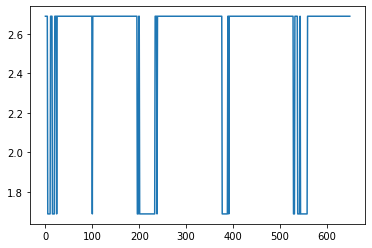

In [61]:
plt.plot(range(0,len(all_losses)),all_losses)